In [1]:
#!pip install causal-learn
#!pip install pygraphviz

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from causallearn.utils.GraphUtils import GraphUtils as gu
from causallearn.search.ConstraintBased.PC import pc
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
%matplotlib inline

In [3]:
vfc = pd.read_csv('variables_for_causality.csv')
vfc.columns

Index(['M_BH', 'log_sigma0', 'log_B.T', 'logRho_soi_approx_new',
       'log_R_e_sph_eq_kpc', 'bvtc', 'M._sph'],
      dtype='object')

Meaning of the quantities
* $\log{M_{BH}}$ means log supermassive black hole mass
* $\log{\sigma_0}$ means log central velocity dispersion
* $\log{B/T}$ means log of the bulge to total mass fractions
* $\log{\rho_\mathrm{SOI}}$ is log stellar density within the sphere of influence of the black hole
* $\log{R_e}$ is log the half-light radius
* $B-V$ is color
* $\log{M_*}$ is stellar mass

In [28]:
vfc.describe()

M_BH  log_sigma0     log_B.T  logRho_soi_approx_new  \
count  104.000000  104.000000  104.000000             104.000000   
mean     8.215096    2.272599   -0.342500               2.749224   
std      0.991215    0.185631    0.327677               0.862977   
min      5.740000    1.538951   -1.160000               0.484590   
25%      7.590000    2.149504   -0.572500               2.135792   
50%      8.260000    2.291300   -0.290000               2.777766   
75%      8.940000    2.417366   -0.020000               3.324352   
max     10.300000    2.594437    0.000000               4.674412   

       log_R_e_sph_eq_kpc        bvtc      M._sph  
count          104.000000  104.000000  104.000000  
mean             0.151778    0.841192   10.646827  
std              0.647024    0.109879    0.773828  
min             -1.239789    0.493000    8.030000  
25%             -0.347755    0.800500   10.110000  
50%              0.059770    0.884500   10.580000  
75%              0.770114    0.916000   11.275000  
max              1.490000    0.975000   12.260000

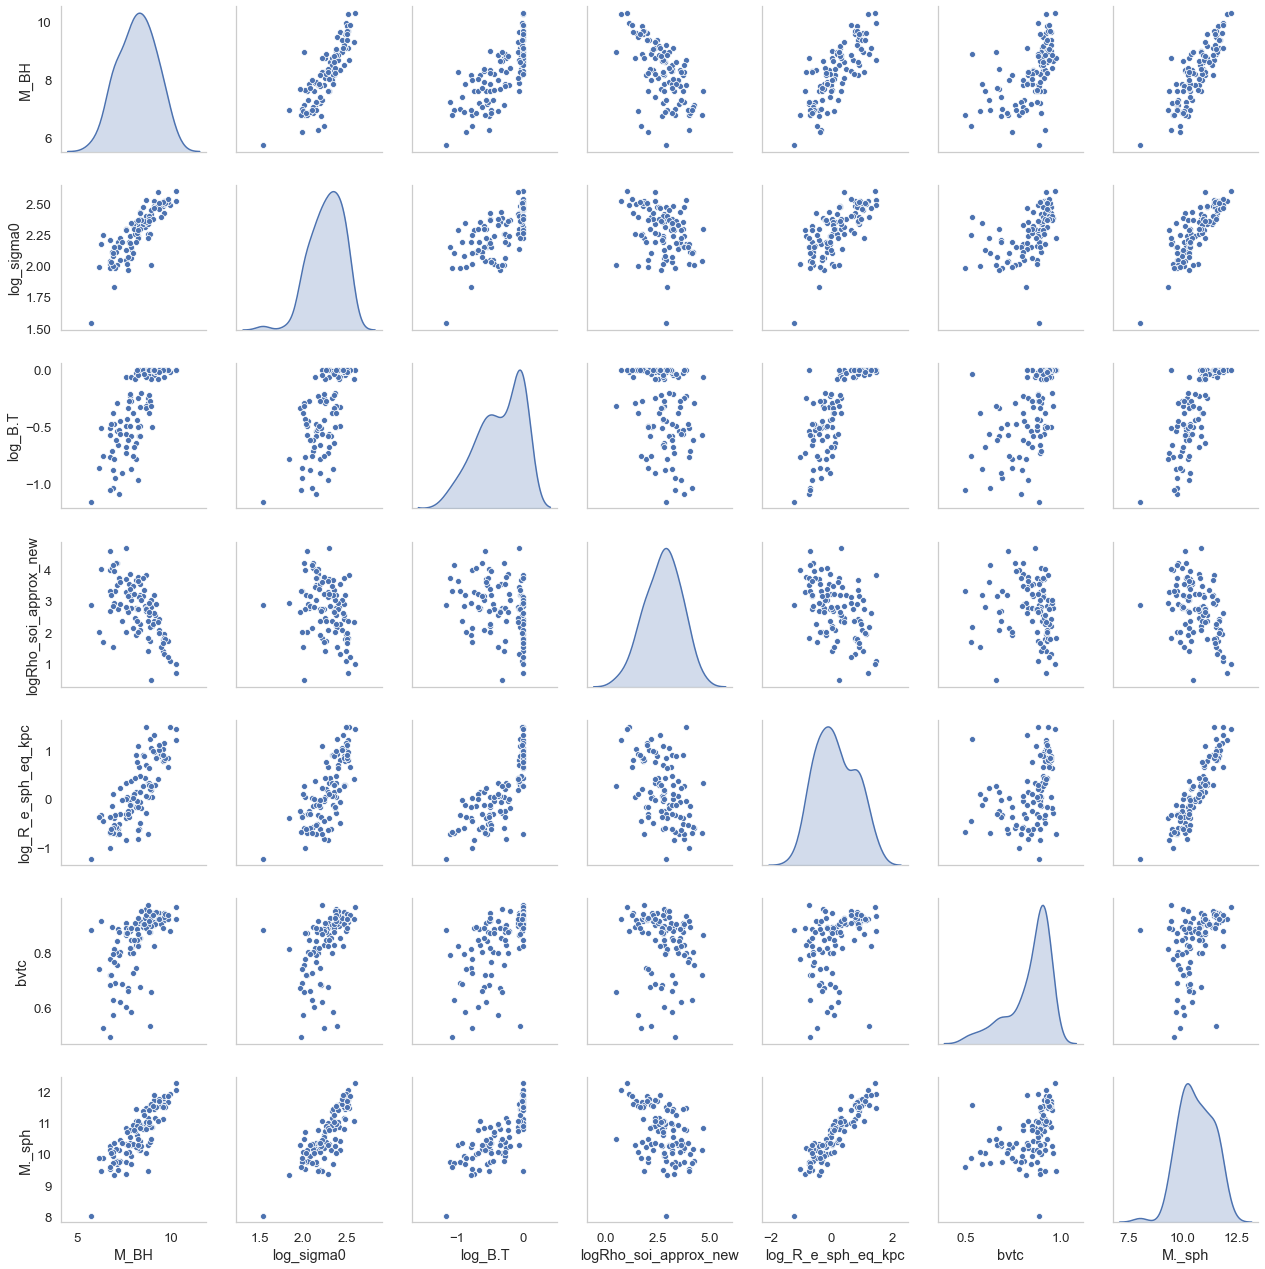

In [56]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(vfc, diag_kind='kde')
plt.show()

#### PC algorithm

We should check what the effect of alpha (significance threshold for independence) is on the resulting DAG! I get slighly different dags setting it to 0.1, 0.05, or 0.01. They are similar to the dags we get by random subsampling.

In [73]:
variable_labels = ['Black hole mass', 'Central velocity dispersion','Bulge to total mass ratio',
                   'Central density','Half-light radius','B-V color',
                   'Total stellar mass']
causality = pc(vfc.to_numpy(), indep_test='kci', show_progress=False, alpha = 0.1) #change alpha...
pyd = gu.to_pydot(causality.G, labels=variable_labels)
pyd.write_png("naive_pc_algorithm_on_all_data_KCI.png")

![PC with KCI test](naive_pc_algorithm_on_all_data_KCI.png)

In [5]:
np.random.seed(888)
causal_structures = []
Nruns = 100
for i in range(Nruns):
    ind = np.random.uniform(size=vfc.shape[0]) > 0.1
    causality = pc(vfc.to_numpy()[ind,], show_progress=False, indep_test='kci')
    causal_structures.append(causality)
    #pyd = gu.to_pydot(causality.G, labels=variable_labels)
    #pyd.write_png("naive_pc_algorithm_subset_" + str(i) + ".png")

#for i in range(10):
#    addu = 0.1*np.random.normal(size=vfc.shape)
#    causality = pc(StandardScaler().fit_transform(vfc.to_numpy())+addu)
#    pyd = gu.to_pydot(causality.G)
#    pyd.write_png("addgau" + str(i) + ".png")

In [6]:
unique_causal_structures = []
for i in range(Nruns):
    isitthere = False
    for j in unique_causal_structures:
        if (causal_structures[i].G == causal_structures[j].G):
            isitthere = True
            break  # Exit the inner loop since a match is found
    if not isitthere:
        unique_causal_structures.append(i)

print(unique_causal_structures)

def duplicates(i):
    unique_element = causal_structures[i]
    count = 0
    for i in range(Nruns):
        if causal_structures[i].G == unique_element.G:
            count += 1
    return count

duplicate_count = []
for i in unique_causal_structures:
    duplicate_count.append(duplicates(i))
    
print(duplicate_count)

DAG_types = pd.DataFrame({"unique_DAG":unique_causal_structures, "duplicates":duplicate_count})

[0, 1, 2, 4, 6, 8, 9, 10, 11, 15, 16, 17, 20, 24, 26, 33, 34, 36, 37, 44, 46, 48, 49, 56, 73, 78, 79, 85, 86, 87, 89, 94, 97]
[4, 23, 3, 8, 1, 6, 4, 1, 4, 6, 5, 1, 1, 2, 1, 1, 1, 6, 1, 1, 1, 3, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [7]:
DAG_types['duplicates'].sum()

100

In [8]:
for i in unique_causal_structures:
    causality = causal_structures[i]
    pyd = gu.to_pydot(causality.G, labels=variable_labels)
    pyd.write_png("naive_pc_algorithm_subset_" + str(i) + "_KCI.png")


In [9]:
DAG_types.sort_values(by='duplicates', ascending=False)

unique_DAG  duplicates
1            1          23
3            4           8
23          56           6
17          36           6
5            8           6
9           15           6
10          16           5
0            0           4
6            9           4
8           11           4
21          48           3
2            2           3
13          24           2
22          49           1
28          86           1
27          85           1
26          79           1
30          89           1
31          94           1
25          78           1
24          73           1
29          87           1
16          34           1
20          46           1
19          44           1
18          37           1
15          33           1
14          26           1
12          20           1
11          17           1
7           10           1
4            6           1
32          97           1

#### One more test: apply random power transformations to variables
First with kci independence test

In [26]:
def apply_random_power_transform(matrix):
    transformed_matrix = np.empty_like(matrix)
    n_columns = matrix.shape[1]
    
    for col_idx in range(n_columns):
        column = matrix[:, col_idx]
        exponent = np.random.uniform(0.5, 2.0)  
        
        transformed_column = np.power(column, exponent)
        transformed_matrix[:, col_idx] = transformed_column
    
    return transformed_matrix

scaled_vfc = MinMaxScaler().fit_transform(vfc.to_numpy())

np.random.seed(888)
causal_structures = []
Nruns = 100
for i in range(Nruns):
    causality = pc(apply_random_power_transform(scaled_vfc), indep_test='kci')
    causal_structures.append(causality)

unique_causal_structures = []
for i in range(Nruns):
    isitthere = False
    for j in unique_causal_structures:
        if (causal_structures[i].G == causal_structures[j].G):
            isitthere = True
            break  # Exit the inner loop since a match is found
    if not isitthere:
        unique_causal_structures.append(i)

print(unique_causal_structures)

def duplicates(i):
    unique_element = causal_structures[i]
    count = 0
    for i in range(Nruns):
        if causal_structures[i].G == unique_element.G:
            count += 1
    return count

duplicate_count = []
for i in unique_causal_structures:
    duplicate_count.append(duplicates(i))
    
DAG_types = pd.DataFrame({"unique_DAG":unique_causal_structures, "duplicates":duplicate_count})

for i in unique_causal_structures:
    causality = causal_structures[i]
    pyd = gu.to_pydot(causality.G, labels=variable_labels)
    pyd.write_png("naive_pc_algorithm_randomtransform_" + str(i) + "_KCI.png")

DAG_types


[0, 1, 6, 7, 8, 13, 19, 63, 70, 87]


unique_DAG  duplicates
0           0          20
1           1          58
2           6           1
3           7           1
4           8           8
5          13           4
6          19           5
7          63           1
8          70           1
9          87           1

#### Other constraint-based algos

In [11]:
from causallearn.search.ConstraintBased.FCI import fci

# default parameters
G, edges = fci(vfc.to_numpy(), indep_test='kci')


# visualization
from causallearn.utils.GraphUtils import GraphUtils

pdy = GraphUtils.to_pydot(G, labels=variable_labels)
pdy.write_png('fci_algorithm_on_all_data_KCI.png')

#### LINGAM

In [64]:
from causallearn.search.FCMBased import lingam
model = lingam.DirectLiNGAM(random_state=888)
model.fit(vfc.to_numpy())

print(vfc.columns)
print(model.causal_order_)
print(vfc.columns[model.causal_order_])
print(model.adjacency_matrix_)

Index(['M_BH', 'log_sigma0', 'log_B.T', 'logRho_soi_approx_new',
       'log_R_e_sph_eq_kpc', 'bvtc', 'M._sph'],
      dtype='object')
[4, 5, 3, 6, 1, 2, 0]
Index(['log_R_e_sph_eq_kpc', 'bvtc', 'logRho_soi_approx_new', 'M._sph',
       'log_sigma0', 'log_B.T', 'M_BH'],
      dtype='object')
[[ 0.          1.90786835  0.35655003 -0.34171629  0.          1.23165266
   0.35041776]
 [ 0.          0.          0.          0.          0.          0.35583131
   0.17212582]
 [ 0.          0.          0.          0.          0.19109733  0.64856591
   0.09380274]
 [ 0.          0.          0.          0.         -0.5962044   0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.06356014  0.
   0.        ]
 [ 0.          0.          0.          0.          0.94290433  0.
   0.        ]]


Independent component analysis (just for fun; if the components are independent then a causal discovery method should always return a disconnected graph, right?)

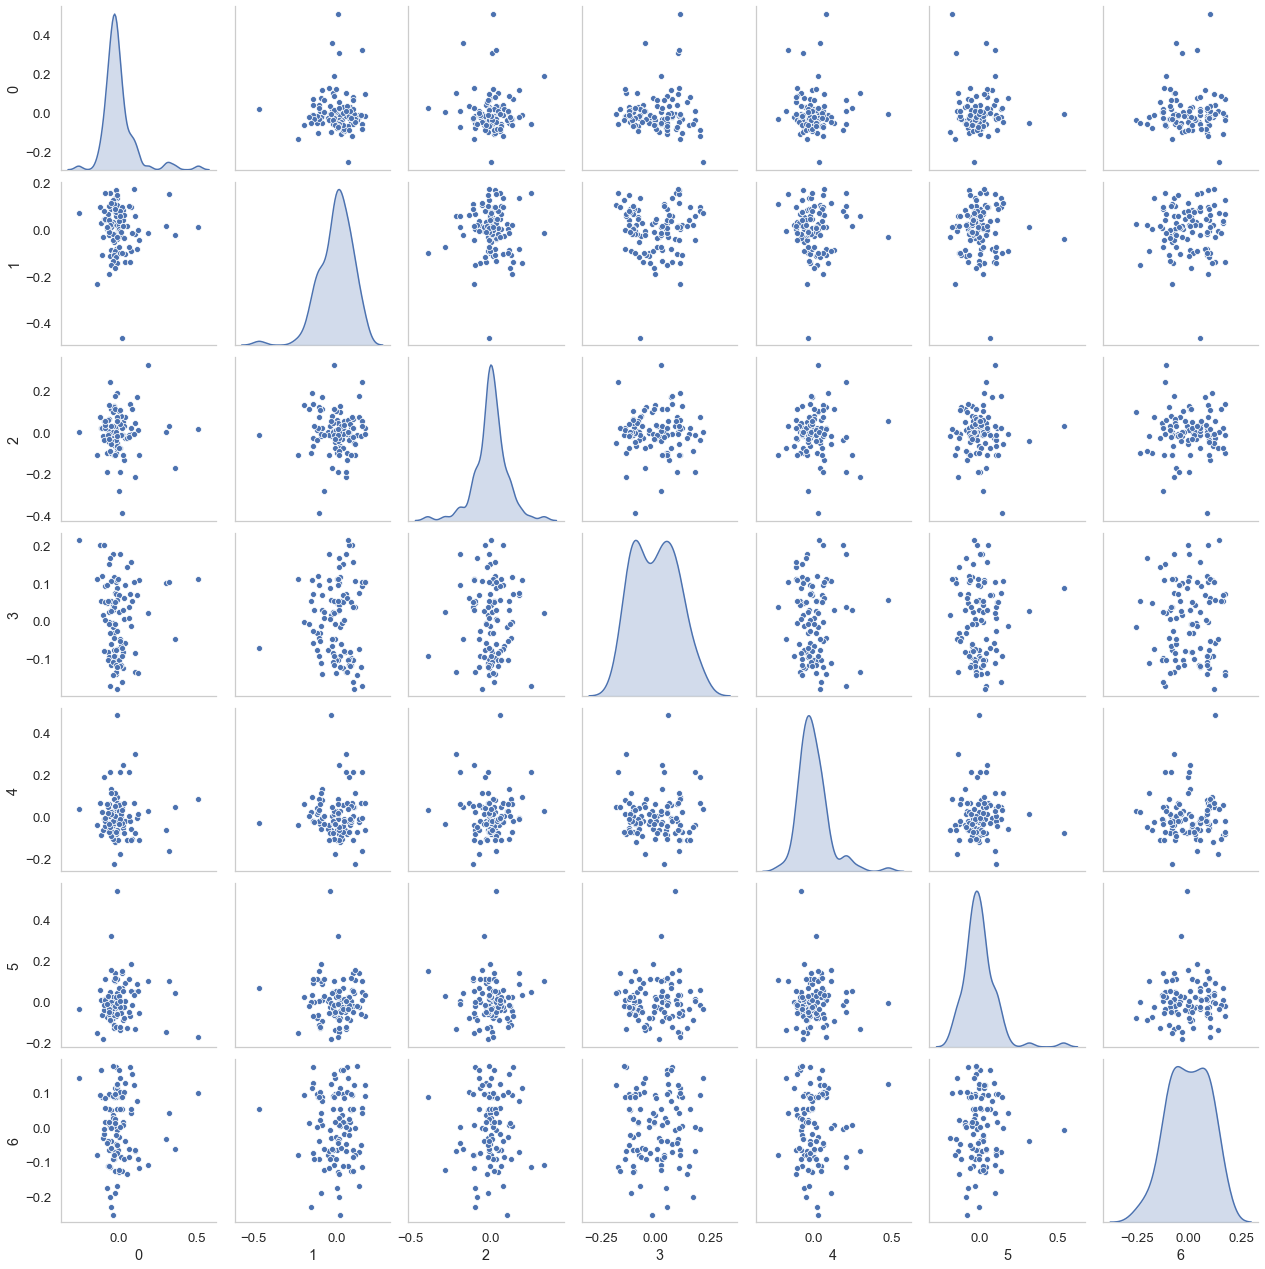

In [68]:
from sklearn.decomposition import FastICA

# Create an instance of FastICA
ica = FastICA(n_components=7)

# Fit the ICA model to your data
icavfc = ica.fit_transform(vfc.to_numpy())

sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(pd.DataFrame(icavfc), diag_kind='kde')
plt.show()

In [69]:
causality_ICA = pc(icavfc, indep_test='kci', show_progress=False, alpha = 0.01)
pyd_ICA = gu.to_pydot(causality_ICA.G)
pyd_ICA.write_png("naive_pc_algorithm_on_all_data_ICAsanitycheck_KCI.png")

![DAG on ICs](naive_pc_algorithm_on_all_data_ICAsanitycheck_KCI.png)

Yes it works!